# Imports

In [1]:
import os 
os.chdir("/home/ivanr/git/document_information_extraction/")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from src.data.wikipedia.wiki_data_base import retrieve_query, retrive_observations_from_ids

# Statics

In [4]:
from src.data.data_statics import INTERIM_DATA_PATH

# Read data

In [59]:
db_path = INTERIM_DATA_PATH / "wiki_db_dumps_test_temp.db"
query = """
    SELECT *
    FROM summary_similarity
   -- limit 125000
"""

In [60]:
a = set(
    [
        i
        for i in string.ascii_letters
        + string.ascii_lowercase
        + string.ascii_uppercase
        + string.punctuation
        + string.digits
        + string.printable
        + "?"
        + "!"
    ]
)
a.difference_update({"[", "]", "\\", '"', "#", "^", "_", "`", "{", "|", "}", "~"})

In [61]:
a

{'\t',
 '\n',
 '\x0b',
 '\x0c',
 '\r',
 ' ',
 '!',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [62]:
data = retrieve_query(query,db_path)

DatabaseError: database disk image is malformed

# Clean up

In [34]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
    
import string

def isEnglish(s):
    return s.translate( string.punctuation).isalnum()

In [35]:
isEnglish("சிவப்பிரகாசர்")

False

In [37]:
# for sent in data:
#     if isEnglish(sent[-1]):
#         pass
#     else:
#         print(sent[-1])
#         print(" ")
        

In [7]:
df = pd.DataFrame(
    [[sent[i] for i in range(6)] for sent in data],
    columns=["id", "page_id", "sent_num", "precision", "recall", "f1"],
)
df

,id,page_id,sent_num,precision,recall,f1
0,3204_0,3204,0,0.461644,0.300576,0.364092
1,3204_1,3204,1,0.438886,0.197765,0.272666
2,3204_2,3204,2,0.360812,0.189371,0.248381
3,3204_3,3204,3,0.459291,0.311655,0.371337
4,24062_0,24062,0,0.577453,0.364849,0.447167
...,...,...,...,...,...,...
124995,46724720_7,46724720,7,0.419997,0.154805,0.226227
124996,46724720_8,46724720,8,0.359422,0.187436,0.246385
124997,46724720_9,46724720,9,0.358884,0.150709,0.212276
124998,46724720_10,46724720,10,0.354009,0.194347,0.250934


# Plot distributions

## Single variable distribution

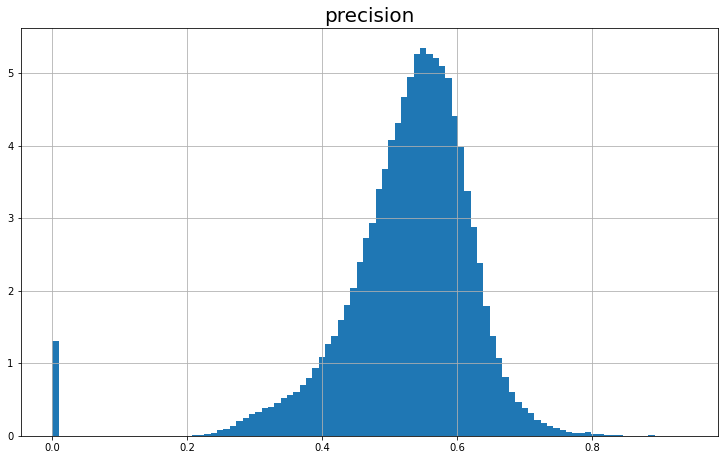

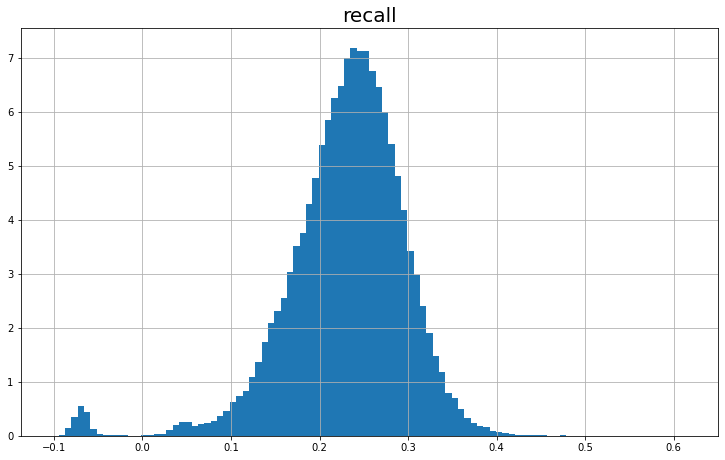

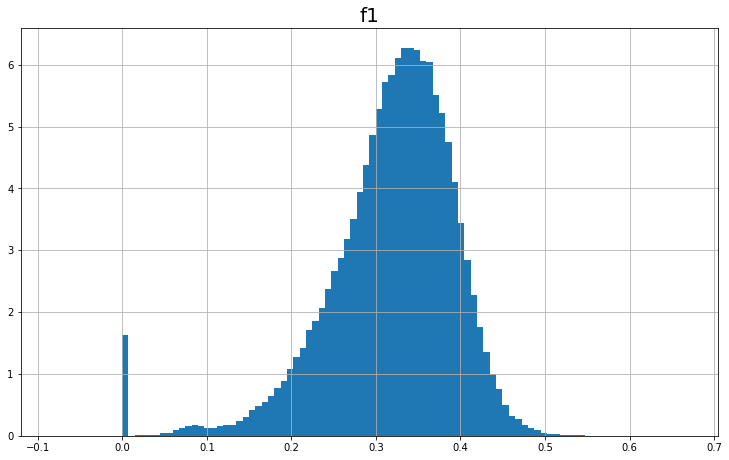

In [10]:
for var in ["precision", "recall", "f1"]:
    plt.figure(figsize = (12.5,7.5))
    plt.title(var, fontsize = 20)
    quantile = df[var].quantile(.99)
    df[var].hist(bins = 100, density = True)
    plt.show()

## Joint distributions

# Sample evaluation

In [ ]:
def evaluate_threshold(df, threshold, metric,n_samples = 5):
    overview = (
        df[df[metric] >= threshold]
        .sort_values(by=metric, ascending=True)
        .head(n_samples)
        .reset_index()
    )
    display(overview)
    overview = list(overview["id"])

    for i in overview:
        print("\n", "-" * 20, i, "-" * 20)
        print("Summary\n")
        print(data_dict[i][-1])
        print("\ntext\n")
        print(
            (
                retrive_observations_from_ids(
                    ids=[int(i.split("_")[0])], out_f=str(db_path)
                )[0][1]
            ).decode()
        )

## f1

In [12]:
for q in np.quantile(df["f1"], [(i+.5)/10 for i in range(10)]):
    evaluate_threshold(df,.5, "f1")

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

,index,id,page_id,sent_num,precision,recall,f1
0,93976,10201962_5,10201962,5,0.695875,0.390515,0.500280
1,116812,24296745_8,24296745,8,0.621765,0.418513,0.500283
2,76569,61679853_0,61679853,0,0.724766,0.382081,0.500375
3,88284,36165931_0,36165931,0,0.686448,0.394079,0.500709
4,48006,66277434_6,66277434,6,0.609182,0.425779,0.501230



 -------------------- 10201962_5 --------------------
Summary

The followed this with The Hairy Bikers Food Tour of Britain, The Hairy Bikers Mums Know Best, Hairy Bikers Meals on Wheels, Hairy Bikers Best of British, The Hairy Bikers Bakeation, Hairy Dieters: How to Love Food and Lose Weight, The Hairy Bikers Asian Adventure, The Hairy Bikers Northern Exposure and The Hairy Bikers Pubs That Built Britain for BBC Two, and The Hairy Bikers Mississippi Adventure for Good Food.

text

David Myers (born 8 September 1957) and Si King (born 20 October 1966) collectively known as the Hairy Bikers, are British television chefs. They have presented a range of television shows that combine cooking with the travelogue format, mostly for the BBC but also for the now-defunct Good Food channel. They have also produced a range of cookery books published to accompany their various television series.
Myers and King have known each other since the 1990s, with both having backgrounds in television produ

## Precision 

In [13]:
for q in np.quantile(df["precision"], [(i+.5)/10 for i in range(10)]):
    evaluate_threshold(df,.5, "precision")

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

,index,id,page_id,sent_num,precision,recall,f1
0,44456,24041724_2,24041724,2,0.500000,0.290680,0.367633
1,112866,11947663_1,11947663,1,0.500001,0.165200,0.248346
2,12190,18057286_4,18057286,4,0.500001,0.272969,0.353144
3,27683,6332750_12,6332750,12,0.500002,0.187786,0.273030
4,86547,345757_17,345757,17,0.500005,0.206113,0.291899



 -------------------- 24041724_2 --------------------
Summary

Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.

text

Founder Juan Hurtado and Hurtan Grand Albaycín.
Hurtan Albaycín T2+2.
Hurtan Albaycín 4P with top up
Hurtan Desarrollos S.L., also known as Hurtan Automóviles, is a Spanish automobile company, founded in 1991 by Juan Hurtado González.
The company is based in Santa Fe, near Granada.
It is an automobile manufacturer of retro-styled vehicles.

 -------------------- 11947663_1 --------------------
Summary

Allan Brocka, who also acts as director.

text

Rick & Steve: The Happiest Gay Couple in All the World (also known as Rick & Steve) is an American-Canadian stop motion animated sitcom created by Q. Allan Brocka, who also acts as director. It is a spin-off from Brockas 1999 short film of the same name, and debuted on the LGBT focused Logo network in July 2007 and on the Canadian Teletoons late-night programming block The Detour that October.
After the first season ai

## Recall

In [14]:
for q in np.quantile(df["recall"], [(i+.5)/10 for i in range(10)]):
    evaluate_threshold(df,.5, "recall")

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist

,index,id,page_id,sent_num,precision,recall,f1
0,19872,28856434_0,28856434,0,0.717073,0.500721,0.589678
1,84905,18074413_0,18074413,0,0.727800,0.502689,0.594653
2,18089,65480847_1,65480847,1,0.656025,0.516258,0.577810
3,84186,10779974_21,10779974,21,0.645221,0.518158,0.574751
4,87590,30251615_0,30251615,0,0.649531,0.525751,0.581123



 -------------------- 28856434_0 --------------------
Summary

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.

text

Sivaprakasa swamigal photo
Siva Prakasar (also Ṣiva Prakāṣa or sometimes Ṣiva-prakāṣa Dēṣikar), was a Tamil ( துறைமங்கலம்
சிவப்பிரகாசர்,
கற்பனைக்களஞ்சியம் ) poet and philosopher lived during the late 17th and early 18th centuries.
He was called Thurai mangalam Sivaprakasar, Karpanai Kalangiyam, Sivanuputhi chelvar. He had contributed more than Thirty four Thamizh books for the Thamizh Literature, the most well known of which is the Nanneri, a work dealing with moral instruction. He is also well known for translating early Kannada works into the Tamil language. and for creating his own poetry.

 -------------------- 18074413_0 --------------------
Summary

The heraldic ensigns of the Minist